<a href="https://colab.research.google.com/github/klsnks/coursework-repository/blob/main/LP_NN_IP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This code provides an estimates of Local Projections with asymmentric effects and regime-dependence

In [3]:
import random
import math
import time
import os

import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim

from sklearn.preprocessing import StandardScaler

In [ ]:
!pip install torchmetrics
from torchmetrics import MeanSquaredError, MeanAbsolutePercentageError

In [ ]:
!pip install -q lightning tbparse

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 32.2 MB/s eta 0:00:00


In [ ]:
import lightning as L
from lightning.pytorch import Trainer
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import ModelCheckpoint

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load Data

In [1]:
# https://docs.google.com/spreadsheets/d/1WxmSasscIuL03aWAXygO0n4WfBRJWkNm/edit?usp=share_link&ouid=110787894887200008166&rtpof=true&sd=true
!gdown 1WxmSasscIuL03aWAXygO0n4WfBRJWkNm


Downloading...
From: https://drive.google.com/uc?id=1WxmSasscIuL03aWAXygO0n4WfBRJWkNm
To: /content/US_BS_series.xlsx
100% 64.9k/64.9k [00:00<00:00, 54.4MB/s]


In [4]:
# Load data
data = pd.read_excel('US_BS_series.xlsx')
date_index = pd.date_range(start="1988-02-01", end="2019-12-01", freq="MS")
data['date'] = date_index

In [5]:
data

,date,IP,unemp,CRB Pcomm,CPI,EBP,2y Treas,MPS,MPS_ORTH,NFP_SURP,NFP_12M,SP500_3M,SLOPE_3M,BCOM_3M,TR_SKEW,EXPINF1YR
0,1988-02-01,62.4169,5.7,554.9076,116.200,0.174158,7.0214,0.0146,-0.0328,0.1510,0.0301,0.0017,-0.82,0.0171,0.2353,3.786656
1,1988-03-01,62.5418,5.7,556.5286,116.500,-0.099543,7.2929,0.0000,0.0000,NaN,NaN,0.0000,0.00,0.0000,0.0000,3.680843
2,1988-04-01,62.8959,5.4,557.4053,117.200,-0.032732,7.5955,0.0637,0.0059,0.0620,0.0323,0.0568,-0.27,0.0277,0.7065,3.981686
3,1988-05-01,62.8223,5.6,560.7822,117.500,0.061701,8.0896,0.1881,0.1703,-0.0800,0.0314,0.0207,0.22,0.0319,0.4207,4.099403
4,1988-06-01,62.9823,5.4,564.8094,118.000,0.164727,7.8851,0.0303,-0.0049,-0.0135,0.0313,0.0136,-0.14,0.1283,0.1736,3.948075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378,2019-08-01,109.8543,3.7,595.8812,256.118,-0.201741,1.5276,0.0000,0.0000,NaN,NaN,0.0000,0.00,0.0000,0.0000,1.714336
379,2019-09-01,109.4725,3.5,595.9896,256.532,-0.291446,1.6560,0.0450,0.0629,-0.0300,0.0123,0.0403,-0.02,0.0253,-0.3557,1.644928
380,2019-10-01,109.0270,3.6,596.4864,257.387,-0.279474,1.5421,0.0298,0.0557,-0.0090,0.0131,-0.0185,0.03,-0.0231,-0.2622,1.724602
381,2019-11-01,110.0388,3.5,595.6977,257.989,-0.230413,1.6416,0.0000,0.0000,NaN,NaN,0.0000,0.00,0.0000,0.0000,1.697300


In [ ]:
# apply log transformations to IP and CPI
data['ln_IP'] = np.log(data['IP'].replace(0, np.nan))  # log of IP
data['ln_CPI'] = np.log(data['CPI'].replace(0, np.nan))  # log of CPI
data['ln_IP_diff'] = data['ln_IP'].diff()
data['ln_CPI_diff'] = data['ln_CPI'].diff()

data['CRB Pcomm'] = np.log(data['CRB Pcomm']).diff()  # log of commodities prices

# # возьмем все в 1 разностях
# columns_to_diff = ['EBP', '2y Treas']
# for col in columns_to_diff:
#     data[col] = data[col].diff()

In [ ]:
data.columns

Index(['date', 'IP', 'unemp', 'CRB Pcomm', 'CPI', 'EBP', '2y Treas', 'MPS',
       'MPS_ORTH', 'NFP_SURP', 'NFP_12M', 'SP500_3M', 'SLOPE_3M', 'BCOM_3M',
       'TR_SKEW', 'EXPINF1YR', 'ln_IP', 'ln_CPI', 'ln_IP_diff', 'ln_CPI_diff'],
      dtype='object')

In [ ]:
# Define alpha values and cycle variables
alpha = [0.125] #[0.05, 0.125, 0.175]
z_t_vars = ['IP', 'unemp']  # Variables responding to the cycle

# Initialize the new DataFrame for regime variables
regime_df = pd.DataFrame(index=data.index)

# Iterate over variables and alphas
for var in z_t_vars:
    for a in alpha:
        z_t_name = f"z_{var}_alpha_{a}"
        regime_df[z_t_name] = 0.0  # Initialize z_t with zeros

        # Compute z_t for the specific variable and alpha
        for t in range(1, len(data)):
            regime_df.loc[t, z_t_name] = (
                a * (data.loc[t, var] - data.loc[t - 1, var])
                + (1 - a) * regime_df.loc[t - 1, z_t_name]
            )

        # Apply transformation 1 / (1 + e^(-z))
        regime_df[z_t_name] = 1 / (1 + np.exp(-regime_df[z_t_name]))

In [ ]:
regime_df

,z_IP_alpha_0.125,z_unemp_alpha_0.125
0,0.500000,0.500000
1,0.503903,0.500000
2,0.514477,0.490626
3,0.510369,0.498047
4,0.514071,0.492042
...,...,...
378,0.529722,0.496389
379,0.514103,0.490591
380,0.498421,0.494892
381,0.530200,0.492406


In [ ]:
figures = []
for var in z_t_vars:
    fig = go.Figure()
    for a in alpha:
        z_t_name = f"z_{var}_alpha_{a}"
        fig.add_trace(go.Scatter(
            x=date_index,
            y=regime_df[z_t_name],
            mode='lines',
            name=f"alpha = {a}"
        ))
    fig.update_layout(
        plot_bgcolor='white',
        title=f"Regime Variables for {var} with Different Alphas",
        xaxis_title="Index",
        yaxis_title=f"Переменная состояния",
        legend_title="Alpha Values"
    )
    figures.append(fig)
    # X-axis formatting
    fig.update_xaxes(showgrid=True, gridcolor='rgba(0, 0, 0, 0.1)')
    fig.update_yaxes(showgrid=True, gridcolor='rgba(0, 0, 0, 0.1)')

# Display the figures
for fig in figures:
    fig.show()

In [ ]:
data = pd.concat([data, regime_df], axis=1)

In [ ]:
print(data.columns)
print(data.shape)

Index(['date', 'IP', 'unemp', 'CRB Pcomm', 'CPI', 'EBP', '2y Treas', 'MPS',
       'MPS_ORTH', 'NFP_SURP', 'NFP_12M', 'SP500_3M', 'SLOPE_3M', 'BCOM_3M',
       'TR_SKEW', 'EXPINF1YR', 'ln_IP', 'ln_CPI', 'ln_IP_diff', 'ln_CPI_diff',
       'z_IP_alpha_0.125', 'z_unemp_alpha_0.125'],
      dtype='object')
(383, 22)


In [ ]:
# Add traget variables
H = 12
y_name = "ln_IP"
# Target variable (y) transformations: y.shift(-H) - y.shift(1), ..., y.shift(0) - y.shift(1)
target_names = []
for h in range(1,(H + 1)):
    data[f'delta_{y_name}_{h}'] = data[y_name].shift(-h) - data[y_name].shift(0)
    target_names.append(f'delta_{y_name}_{h}')


In [ ]:
data.columns

Index(['date', 'IP', 'unemp', 'CRB Pcomm', 'CPI', 'EBP', '2y Treas', 'MPS',
       'MPS_ORTH', 'NFP_SURP', 'NFP_12M', 'SP500_3M', 'SLOPE_3M', 'BCOM_3M',
       'TR_SKEW', 'EXPINF1YR', 'ln_IP', 'ln_CPI', 'ln_IP_diff', 'ln_CPI_diff',
       'z_IP_alpha_0.125', 'z_unemp_alpha_0.125', 'delta_ln_IP_1',
       'delta_ln_IP_2', 'delta_ln_IP_3', 'delta_ln_IP_4', 'delta_ln_IP_5',
       'delta_ln_IP_6', 'delta_ln_IP_7', 'delta_ln_IP_8', 'delta_ln_IP_9',
       'delta_ln_IP_10', 'delta_ln_IP_11', 'delta_ln_IP_12'],
      dtype='object')

In [ ]:
# Define the function to prepare the data based on the given transformations
def prepare_data(df, y_name, e_name, s_name, x_name):
    data = pd.DataFrame()
    # Target variable (y) transformations: y.shift(-H) - y.shift(1), ..., y.shift(0) - y.shift(1)
    data[y_name] = df[y_name]
    # Shocks (e_name)
    data[e_name] = df[e_name]
    # State variables (s_name) with 1 lag
    data[f'{s_name}'] = df[s_name].shift(0)
    # Additional control variables (x_name) with 1 lag
    for var in x_name:
        data[f'{var}'] = df[var].shift(1)
    # Drop rows with any NaN values created by the shifts
    data.dropna(inplace=True)

    return data

# Set spec

In [ ]:
H = 12
# y_name='delta_ln_IP_3' # норм
# y_name='delta_ln_IP_6' # норм
# y_name='delta_ln_IP_12'  # норм
y_name='delta_ln_IP_1'
e_name='MPS_ORTH'
s_name='z_IP_alpha_0.125'
x_name=['ln_CPI_diff', 'ln_IP_diff', 'EBP', '2y Treas']
# Prepare the data using the function
df_prep = prepare_data(data, y_name, e_name, s_name, x_name)

In [ ]:
print(df_prep.shape) #(380, 7)
df_prep.head()

(380, 7)


,delta_ln_IP_1,MPS_ORTH,z_IP_alpha_0.125,ln_CPI_diff,ln_IP_diff,EBP,2y Treas
2,-0.001171,0.0059,0.514477,0.002578,0.001999,-0.099543,7.2929
3,0.002544,0.1703,0.510369,0.005991,0.005646,-0.032732,7.5955
4,0.000429,-0.0049,0.514071,0.002556,-0.001171,0.061701,8.0896
5,0.004165,0.0322,0.513156,0.004246,0.002544,0.164727,7.8851
6,-0.002743,0.1516,0.519723,0.004228,0.000429,-0.138521,8.2453


In [ ]:
# Нормализация данных
scaler = StandardScaler()

# Деление данных на train и val для временных рядов
train_size = int(len(df_prep) * 0.8)
train_data = df_prep.iloc[:train_size]
val_data = df_prep.iloc[train_size:]

# Нормализация данных
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_data)  # fit только на train
val_scaled = scaler.transform(val_data)  # transform на val

# Преобразование обратно в DataFrame для использования с TabularDataset
train_data_scaled = pd.DataFrame(train_scaled, columns=df_prep.columns)
val_data_scaled = pd.DataFrame(val_scaled, columns=df_prep.columns)

class TabularDataset(Dataset):
    def __init__(self, data):
        self.data = data
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        # Выделяем признаки (features) и целевую переменную (target)
        x = torch.tensor(self.data.iloc[idx, 1:].values, dtype=torch.float32)  # Features
        y = torch.tensor(self.data.iloc[idx, 0], dtype=torch.float32)  # Target
        return x, y

# Создание DataLoader
train_dataset = TabularDataset(train_data_scaled)
val_dataset = TabularDataset(val_data_scaled)

train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=20, shuffle=False)

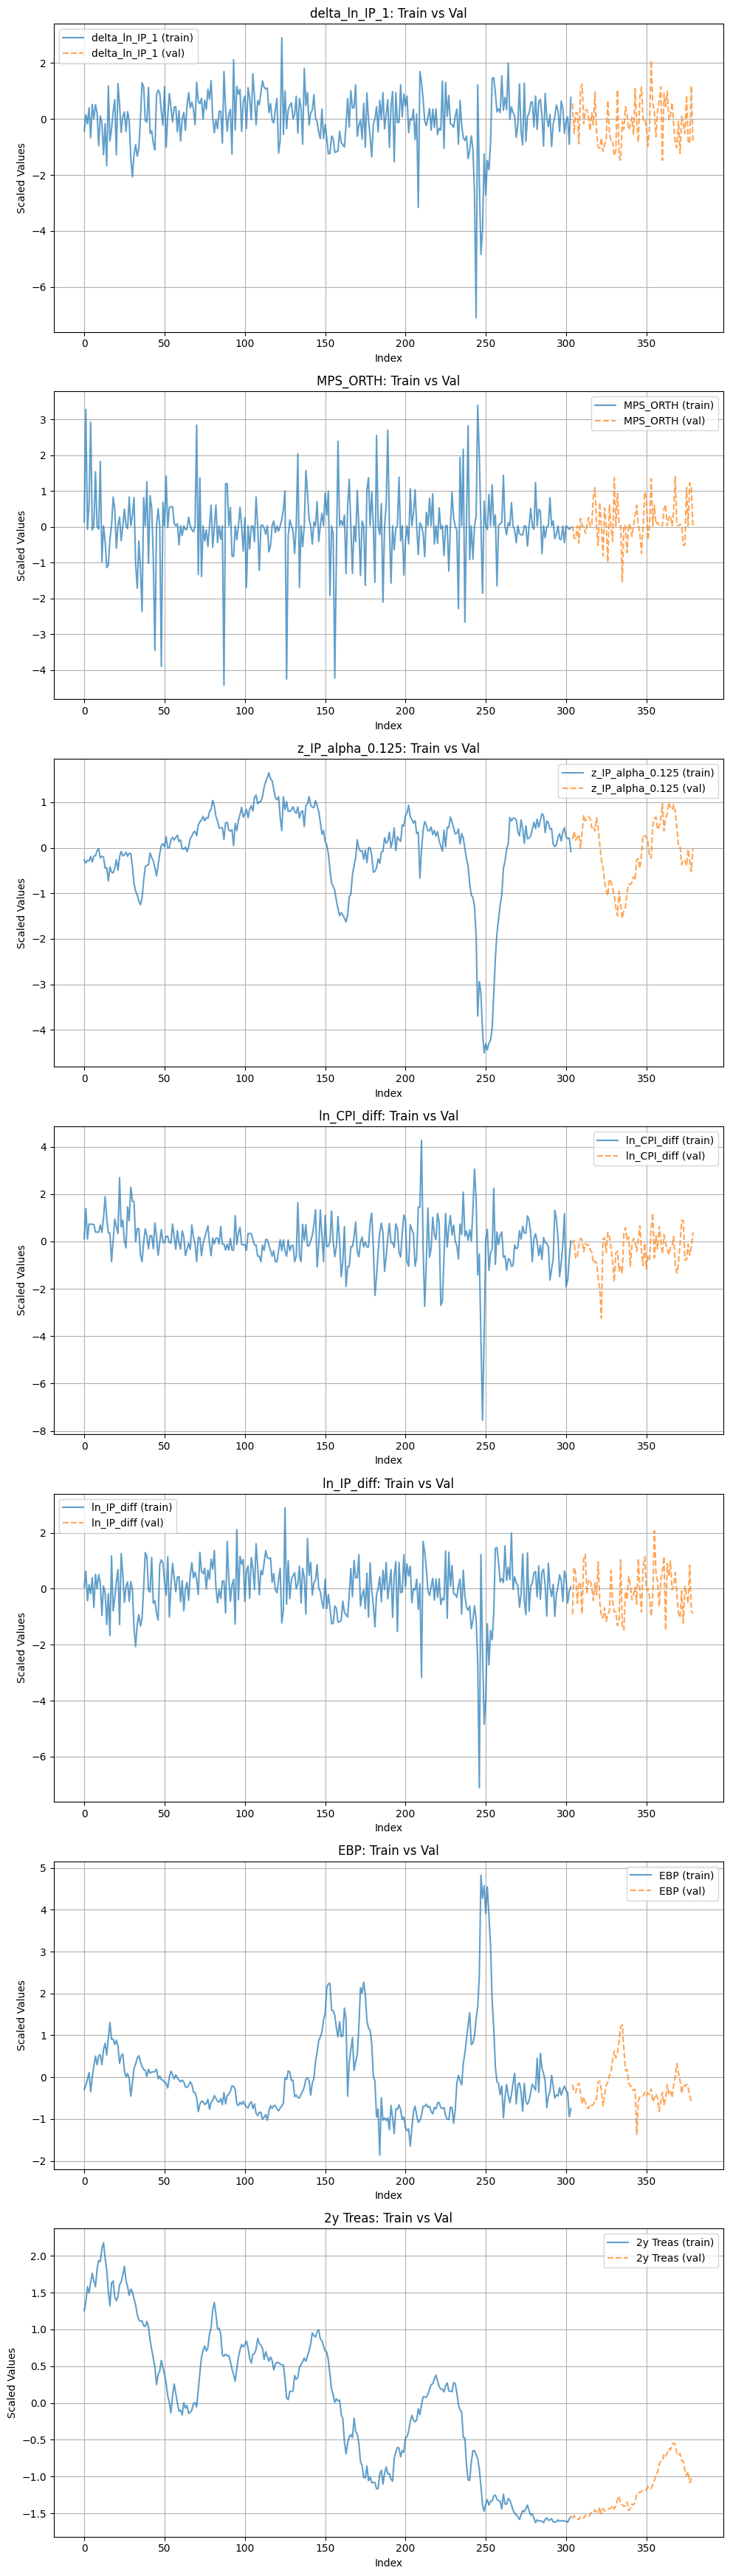

In [ ]:
import matplotlib.pyplot as plt
# Присоединение val_scaled к train_scaled
all_scaled = np.vstack((train_scaled, val_scaled))

# Создание индексов для выделения train и val
train_indices = np.arange(len(train_scaled))
val_indices = np.arange(len(train_scaled), len(all_scaled))

# Построение отдельных графиков для каждой переменной
num_vars = train_scaled.shape[1]
fig, axes = plt.subplots(num_vars, 1, figsize=(10, 5 * num_vars))

for i, (column, ax) in enumerate(zip(df_prep.columns, axes)):
    ax.plot(train_indices, train_scaled[:, i], label=f'{column} (train)', alpha=0.7)
    ax.plot(val_indices, val_scaled[:, i], label=f'{column} (val)', alpha=0.7, linestyle='--')
    ax.set_title(f'{column}: Train vs Val')
    ax.set_xlabel('Index')
    ax.set_ylabel('Scaled Values')
    ax.legend()
    ax.grid()

plt.tight_layout()
plt.show()


# Model

In [ ]:
# Определение простой нейронной сети
class SimpleNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = torch.nn.Linear(input_dim, hidden_dim)
        # self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
# Neural Network for Asymmetric Component
class AsymmetricNN(nn.Module):
    def __init__(self, hidden_size):
        super(AsymmetricNN, self).__init__()
        self.hidden = nn.Linear(2, hidden_size)  # Input size is now 2 (e_t and S_t)
        self.output = nn.Linear(hidden_size, 1)
        self.activation = nn.Tanh()

    def forward(self, e_t, S_t):
        x = torch.cat((e_t, S_t), dim=1)  # Concatenate e_t and S_t along the feature dimension
        x = self.activation(self.hidden(x))
        return self.output(x)

# IALP Model
class IALPModel(nn.Module):
    def __init__(self, input_dim, hidden_size):
        super(IALPModel, self).__init__()
        self.alpha = nn.Parameter(torch.zeros(1))  # Intercept
        self.beta = nn.Parameter(torch.zeros(1))   # Linear effect of shock
        self.gamma = nn.Parameter(torch.zeros(1))  # Scaling factor for asymmetry
        self.delta = nn.Linear((input_dim - 2), 1, bias=False)  # Control variables
        self.asymmetric_nn = AsymmetricNN(hidden_size=hidden_size)

    def forward(self, x):
        e_t, S_t, X_t = x[:, 0:1], x[:, 1:2], x[:, 2:]  # Extract e_t, S_t, and X_t
        const_term = self.alpha
        baseline = self.beta * e_t
        asymmetry = self.gamma * self.asymmetric_nn(e_t, S_t)  # Pass both e_t and S_t to AsymmetricNN
        control_effect = self.delta(X_t)
        return const_term + baseline + asymmetry + control_effect

In [ ]:
# Lightning-модуль
class SimpleNNLightningModule(L.LightningModule):
    def __init__(self, input_dim, hidden_dim, lr=1e-4):
        super().__init__()
        # self.model = SimpleNN(input_dim, hidden_dim)
        self.model = IALPModel(input_dim=input_dim, hidden_size=hidden_dim)
        self.lr = lr
        self.train_mse = MeanSquaredError()
        self.val_mse = MeanSquaredError()

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        return torch.optim.AdamW(self.model.parameters(), lr=self.lr)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x).squeeze()
        # loss = F.mse_loss(y_pred, y)
        loss = F.huber_loss(y_pred, y)
        self.log("train_loss", loss, prog_bar=True)
        self.train_mse.update(y_pred, y)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x).squeeze()
        # loss = F.mse_loss(y_pred, y)
        loss = F.huber_loss(y_pred, y)
        self.log("val_loss", loss, prog_bar=True)
        self.val_mse.update(y_pred, y)
        return loss

    def on_training_epoch_end(self):
        train_mse = self.train_mse.compute()
        self.log("train_mse_epoch", train_mse, prog_bar=True)
        self.train_mse.reset()

    def on_validation_epoch_end(self):
        val_mse = self.val_mse.compute()
        self.log("val_mse_epoch", val_mse, prog_bar=True)
        self.val_mse.reset()

# Train Model

In [ ]:
pip install tensorboard

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir logs/LP

In [ ]:
# Настройка обучения
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    dirpath="checkpoints/",
    filename="best_model",
    save_top_k=1,
    mode="min"
)

logger = TensorBoardLogger(save_dir="logs/LP", name="ip12")

trainer = Trainer(
    max_epochs=150,
    logger=logger,
    callbacks=[checkpoint_callback],
    devices="auto",
    enable_progress_bar=True
)

# Инициализация модели и обучение
input_dim = df_prep.shape[1] - 1  # Количество признаков
hidden_dim = 15 # 15 ok

model = SimpleNNLightningModule(input_dim=input_dim, hidden_dim=hidden_dim)
trainer.fit(model, train_loader, val_loader)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: UserWarning:

Checkpoint directory /content/checkpoints exists and is not empty.

INFO: 
  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | IALPModel        | 68     | train
1 | train_mse | MeanSquaredError | 0      | train
2 | val_mse   | MeanSquaredError | 0      | train
-------------------------------------------------------
68        Trainable params
0         Non-trainable params
68        Total params
0.000     Total estimated model params size (MB)
8      

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/fit_loop.py:298: PossibleUserWarning:

The number of training batches (16) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.



Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=150` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=150` reached.


In [ ]:
# Calculate min, max, mean, and median for all_scaled data
all_scaled_min = np.min(all_scaled, axis=0)
all_scaled_max = np.max(all_scaled, axis=0)
all_scaled_mean = np.mean(all_scaled, axis=0)
all_scaled_median = np.median(all_scaled, axis=0)

# Combine results into a DataFrame for better visualization
stats_df = pd.DataFrame({
    'Variable': df_prep.columns,
    'Min': all_scaled_min,
    'Max': all_scaled_max,
    'Mean': all_scaled_mean,
    'Median': all_scaled_median
})
stats_df

,Variable,Min,Max,Mean,Median
0,delta_ln_IP_1,-7.099991,2.893619,-0.020689,0.042635
1,MPS_ORTH,-4.427535,3.391964,0.027820,0.026852
2,z_IP_alpha_0.125,-4.504013,1.646431,-0.013627,0.183221
3,ln_CPI_diff,-7.548692,4.269512,-0.070416,-0.056224
4,ln_IP_diff,-7.114681,2.895782,-0.022658,0.050753
5,EBP,-1.864437,4.823736,-0.048938,-0.247517
6,2y Treas,-1.627376,2.178883,-0.240641,-0.186757


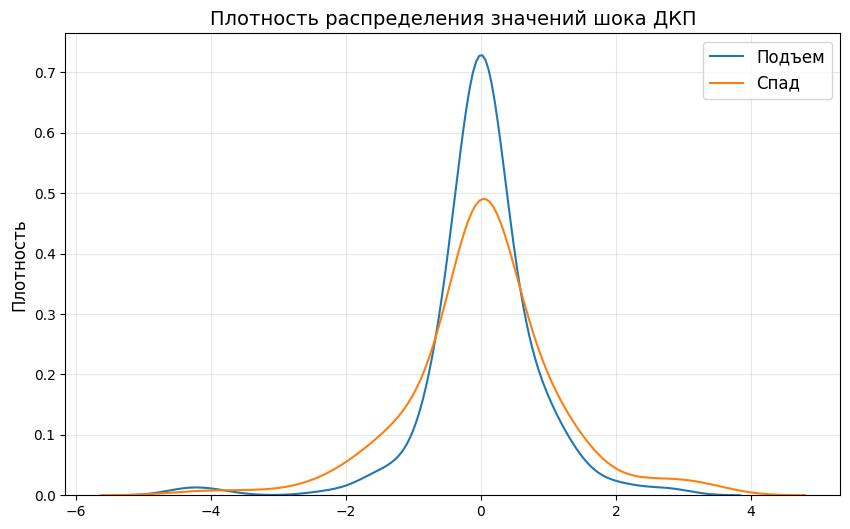

In [ ]:
import seaborn as sns
# Условные выборки
data_condition_1 = all_scaled[all_scaled[:, 2] > 0, 1]
data_condition_2 = all_scaled[all_scaled[:, 2] < 0, 1]

# Построение функций плотности
plt.figure(figsize=(10, 6))
sns.kdeplot(data_condition_1, label='Подъем', bw_adjust=1.2)
sns.kdeplot(data_condition_2, label='Спад', bw_adjust=1.2)

# Настройки графика
plt.title('Плотность распределения значений шока ДКП', fontsize=14)
# plt.xlabel('Значения all_scaled[:, 1]', fontsize=12)
plt.ylabel('Плотность', fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.show()

In [ ]:
# Extract mean values for all variables
mean_values = np.mean(all_scaled, axis=0)

# Define MPS_ORTH and z_IP_alpha_0.125 test values
MPS_ORTH_values = [0, -2, 2]
z_IP_alpha_values = [-1, 1]

# Create the test dataset
test_data = []
for MPS_ORTH in MPS_ORTH_values:
    for z_IP_alpha in z_IP_alpha_values:
        test_row = mean_values.copy()
        # Update specific variables
        test_row[df_prep.columns.get_loc(e_name)] = MPS_ORTH
        test_row[df_prep.columns.get_loc(s_name)] = z_IP_alpha
        test_data.append(test_row)

# Convert to DataFrame for visualization
test_dataset = pd.DataFrame(test_data, columns=df_prep.columns)
test_dataset = test_dataset.drop(columns=[test_dataset.columns[0]])
test_dataset = test_dataset.sort_values(by=s_name).reset_index(drop=True)

test_dataset

,MPS_ORTH,z_IP_alpha_0.125,ln_CPI_diff,ln_IP_diff,EBP,2y Treas
0,0.0,-1.0,-0.070416,-0.022658,-0.048938,-0.240641
1,-2.0,-1.0,-0.070416,-0.022658,-0.048938,-0.240641
2,2.0,-1.0,-0.070416,-0.022658,-0.048938,-0.240641
3,0.0,1.0,-0.070416,-0.022658,-0.048938,-0.240641
4,-2.0,1.0,-0.070416,-0.022658,-0.048938,-0.240641
5,2.0,1.0,-0.070416,-0.022658,-0.048938,-0.240641


In [ ]:
# Adjust the calculation of mean values based on z_IP_alpha_values conditions
mean_negative = np.mean(
    all_scaled[all_scaled[:, df_prep.columns.get_loc('z_IP_alpha_0.125')] < 0], axis=0
)
mean_positive = np.mean(
    all_scaled[all_scaled[:, df_prep.columns.get_loc('z_IP_alpha_0.125')] > 0], axis=0
)

# Define MPS_ORTH and z_IP_alpha_0.125 test values
MPS_ORTH_values = [0, -2, 2]
z_IP_alpha_values = [-1, 1]

# Create the test dataset
test_data = []
for MPS_ORTH in MPS_ORTH_values:
    for z_IP_alpha in z_IP_alpha_values:
        # Use appropriate means based on the condition
        if z_IP_alpha == -1:
            test_row = mean_negative.copy()
        else:
            test_row = mean_positive.copy()
        # Update specific variables
        test_row[df_prep.columns.get_loc('MPS_ORTH')] = MPS_ORTH
        test_row[df_prep.columns.get_loc('z_IP_alpha_0.125')] = z_IP_alpha
        test_data.append(test_row)

# Convert to DataFrame for visualization
test_dataset = pd.DataFrame(test_data, columns=df_prep.columns)
test_dataset = test_dataset.drop(columns=[test_dataset.columns[0]])
test_dataset = test_dataset.sort_values(by='z_IP_alpha_0.125').reset_index(drop=True)

test_dataset

,MPS_ORTH,z_IP_alpha_0.125,ln_CPI_diff,ln_IP_diff,EBP,2y Treas
0,0.0,-1.0,0.000753,-0.428855,0.493514,-0.201522
1,-2.0,-1.0,0.000753,-0.428855,0.493514,-0.201522
2,2.0,-1.0,0.000753,-0.428855,0.493514,-0.201522
3,0.0,1.0,-0.118912,0.254131,-0.418573,-0.267298
4,-2.0,1.0,-0.118912,0.254131,-0.418573,-0.267298
5,2.0,1.0,-0.118912,0.254131,-0.418573,-0.267298


In [ ]:
# Prepare the test dataset (convert to PyTorch tensor)
test_tensor = torch.tensor(test_dataset.values, dtype=torch.float32)
# Make predictions
with torch.no_grad():  # Disable gradient computation for inference
    predictions = model(test_tensor)
# Convert predictions to a NumPy array for easier handling
predictions = predictions.cpu().numpy()

In [ ]:
predictions

array([[-0.11054322],
       [-0.1486952 ],
       [-0.04060867],
       [ 0.28229988],
       [ 0.22752291],
       [ 0.29356465]], dtype=float32)

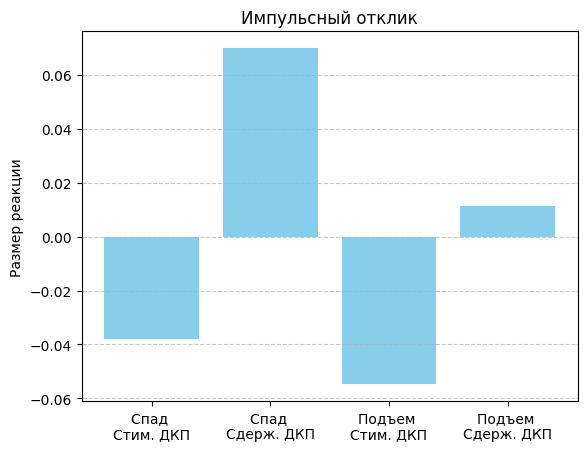

In [ ]:
import matplotlib.pyplot as plt
import datetime
# Compute differences and ensure values are scalars
points = {
    'Спад \nСтим. ДКП': float((predictions[1] - predictions[0]).item()),
    'Спад \nСдерж. ДКП': float((predictions[2] - predictions[0]).item()),
    'Подъем \nСтим. ДКП': float((predictions[4] - predictions[3]).item()),
    'Подъем \nСдерж. ДКП': float((predictions[5] - predictions[3]).item()),
}

# Create bar plot
plt.bar(points.keys(), points.values(), color='skyblue')
plt.title("Импульсный отклик")
plt.ylabel("Размер реакции")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
# Assuming `predictions` is already defined with proper values
points = {
    'Спад <br>Стим. ДКП': float((predictions[1] - predictions[0]).item()),
    'Спад <br>Сдерж. ДКП': float((predictions[2] - predictions[0]).item()),
    'Подъем <br>Стим. ДКП': float((predictions[4] - predictions[3]).item()),
    'Подъем <br>Сдерж. ДКП': float((predictions[5] - predictions[3]).item()),
}

# Create bar plot
fig = go.Figure(
    data=go.Bar(
        x=list(points.keys()),
        y=list(points.values()),
        marker_color='skyblue'
    )
)
# Add a horizontal line at y = 0
fig.add_shape(
    type="line",
    x0=-0.5,  # Start slightly before the first bar
    x1=3.5,   # End slightly after the last bar
    y0=0,
    y1=0,
    line=dict(color="black", width=1)
)

# Customize layout
fig.update_layout(
    title="Импульсный отклик",
    yaxis=dict(
        title="Размер реакции",
        gridcolor='lightgray',
        gridwidth=0.5
    ),
    xaxis=dict(
        tickmode='array',
        tickvals=list(points.keys())
    ),
    plot_bgcolor='white',
    width=500,  # Set the width of the figure
    height=400  # Set the height of the figure
)

fig.show()

In [ ]:
# # save current model
# !zip -r logs_version_7.zip /content/checkpoints/best_model-v36.ckpt
# from google.colab import files
# files.download("logs_version_7.zip")

  adding: content/checkpoints/best_model-v36.ckpt (deflated 65%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>